In [1]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

paths_to_image = ["TCGA_CS_4941_19960909_11.tif",
                  "TCGA_CS_4943_20000902_18.tif",
                  "TCGA_CS_6665_20010817_18.tif",
                  "TCGA_DU_5855_19951217_23.tif"]

path_to_model = "clf-resnet-weights.hdf5"
model = tf.keras.models.load_model(path_to_model)
img_array = np.empty([len(paths_to_image),256,256,3])
counter = 0
for path_to_image in paths_to_image:
    img = cv2.imread(path_to_image)
    img = img / 255.0 # we need to normalise (but see what happens if you don't)
    #img = np.expand_dims(img, axis=0)
    img_array[counter] = img
    counter += 1
img_array = img_array.astype('float32')

classes = ['No Tumour', 'Tumour']

In [2]:
def top_k_predictions(img, k=1):
  image_batch = tf.expand_dims(img, 0)
  predictions = model.predict(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = classes[int(top_idxs)]
  return top_labels, top_probs[0]

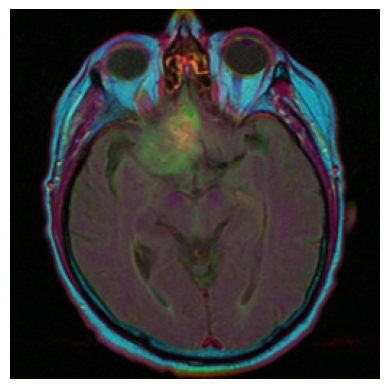

1/1 [==============================] - 1s 806ms/step
Tumour: 73.1%


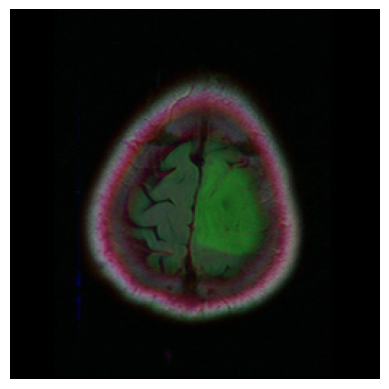

1/1 [==============================] - 0s 111ms/step
Tumour: 73.1%


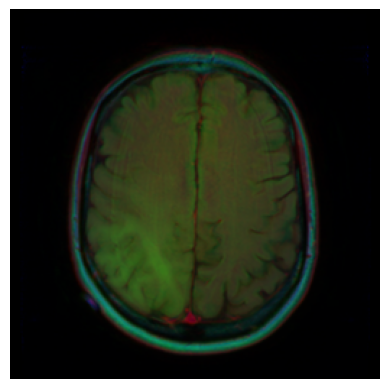

1/1 [==============================] - 0s 116ms/step
Tumour: 73.1%


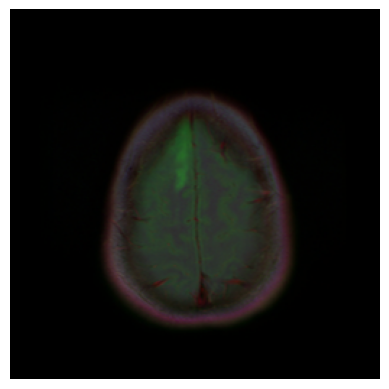

1/1 [==============================] - 0s 113ms/step
Tumour: 73.1%


In [3]:
for (img_tensor) in img_array:
  plt.imshow(img_tensor)
  #plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  print(f'{pred_label}: {pred_prob.numpy()[0]:0.1%}')

In [4]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

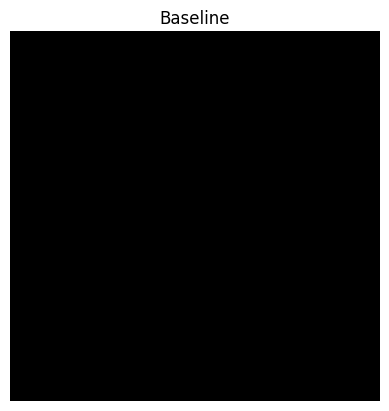

In [5]:
baseline = tf.zeros(shape=(img_array[0].shape[0],img_array[0].shape[1],3))
baseline_2 = tf.random.uniform(shape=(img_array[0].shape[0],img_array[0].shape[1],3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [6]:
m_steps=200
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [7]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [8]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_array[0],
    alphas=alphas)

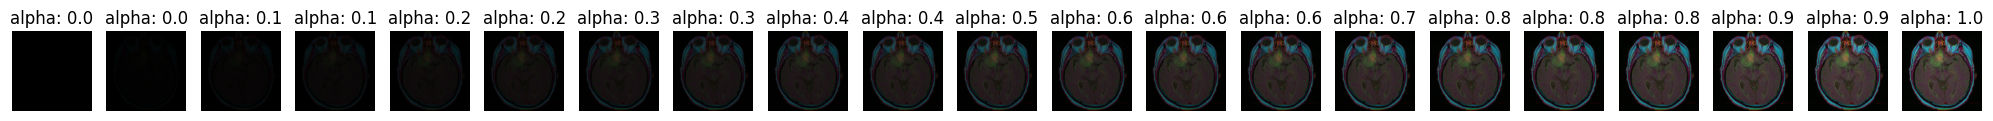

In [9]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [10]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [11]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=1)

print(path_gradients.shape)

(201, 256, 256, 3)


In [12]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [13]:
ig = integral_approximation(
    gradients=path_gradients)

float(sum(sum(sum(ig))))

0.8205847144126892

In [14]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [15]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [16]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_array[0],
                                       target_class_idx=1,
                                       m_steps=240)

In [17]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
  non_abs_attribution_mask = tf.reduce_sum(attributions, axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')
  
  plt.tight_layout()
  return non_abs_attribution_mask

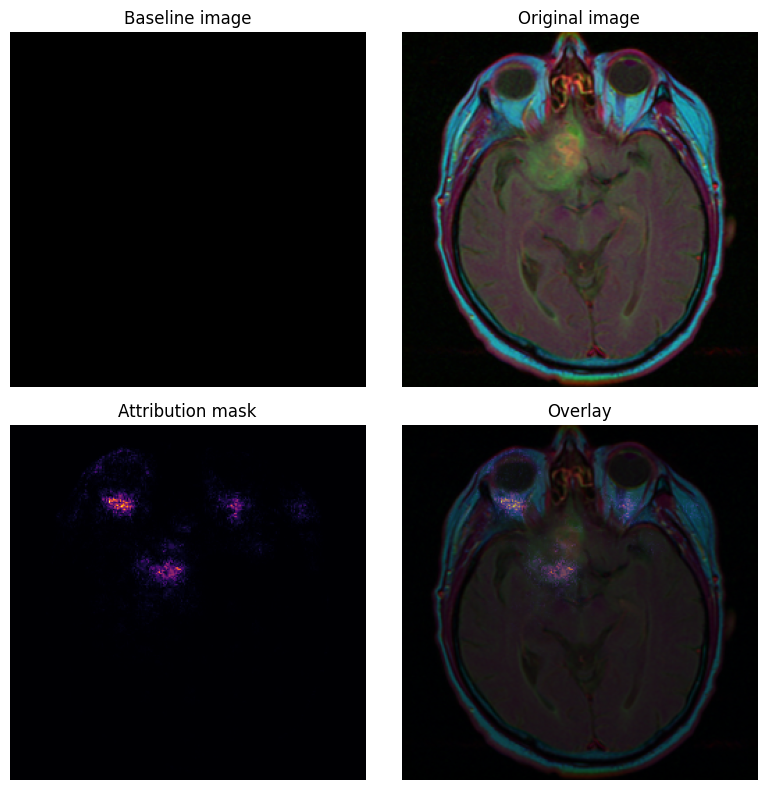

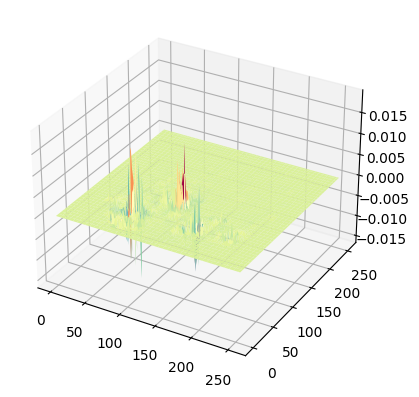

In [18]:
attribution_mask = plot_img_attributions(image=img_array[0],
                          baseline=baseline,
                          target_class_idx=1,
                          m_steps=2000,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

element = attribution_mask.numpy()
x = np.arange(0, element.shape[1])
y = np.arange(0, element.shape[0])
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, element, cmap = 'Spectral_r')

plt.show()

In [19]:

sum_mask = sum(sum(attribution_mask.numpy()))

pred_img = model(np.expand_dims(img_array[0], axis=0))
probs_img = tf.nn.softmax(pred_img, axis=-1)[:, 1]
pred_baseline = model(np.expand_dims(baseline, axis=0))
probs_baseline = tf.nn.softmax(pred_baseline, axis=-1)[:, 1]

difference = probs_img - probs_baseline

print(f'Image prediction is: {probs_img} and baseline: {probs_baseline}')
print(f'The difference is {difference}')
print(f'Sum of attribution masks: {sum_mask}')

Image prediction is: [0.7310584] and baseline: [0.26894164]
The difference is [0.46211678]
Sum of attribution masks: 0.4623709142711441


In [20]:
pred_img

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[3.8216595e-07, 9.9999964e-01]], dtype=float32)>

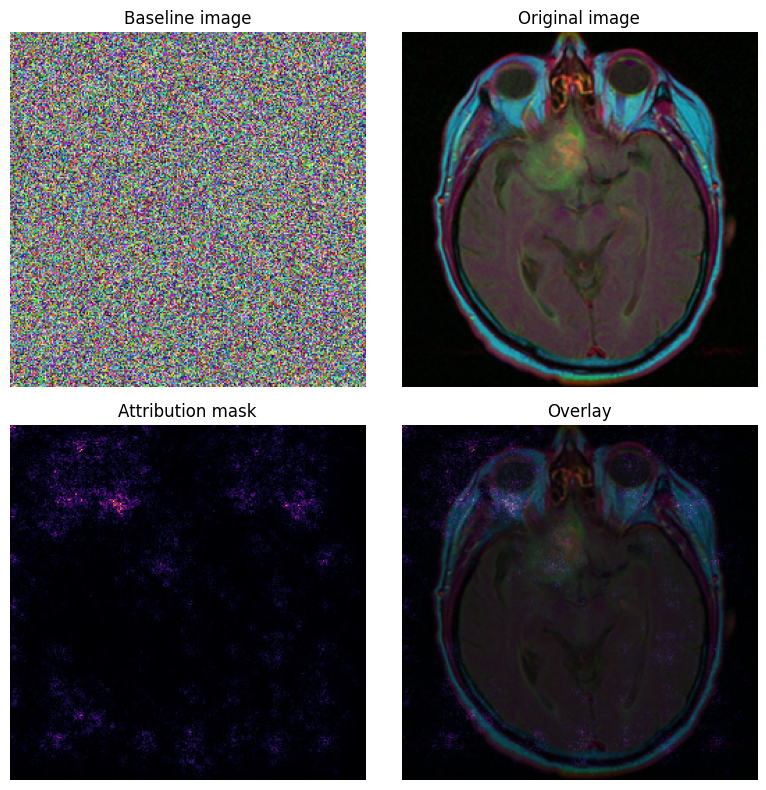

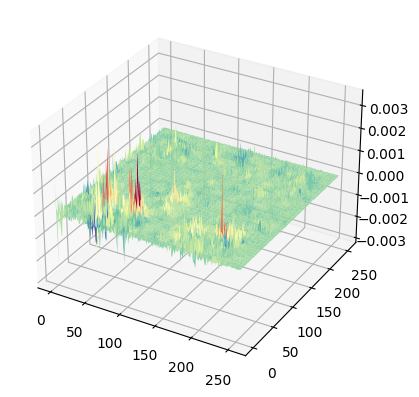

In [21]:
attribution_mask = plot_img_attributions(image=img_array[0],
                          baseline=baseline_2,
                          target_class_idx=1,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

element = attribution_mask.numpy()
x = np.arange(0, element.shape[1])
y = np.arange(0, element.shape[0])
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, element, cmap = 'Spectral_r')

plt.show()

# Explanation of IG


## Intuition

The main reasoning behind Integrated Gradients is that it takes the derivative of the path between the baseline and the input over each individual feature. In addition, it integrates that derivative, which will result in the contribution of the specific feature.

Intuitively, the difference between the baseline and the input can be defined as the sum of all the attributions. This property is known as **completeness**

* [SYMMETRY-PRESERVING PATHS IN INTEGRATED GRADIENTS](https://mlerma54.github.io/papers-and-preprints/ig-symmetry-preserving.pdf)
* [IG original paper](https://arxiv.org/pdf/1703.01365.pdf)
* [A rigorous analysis of IG](https://proceedings.mlr.press/v162/lundstrom22a/lundstrom22a.pdf)
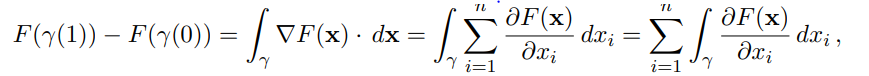

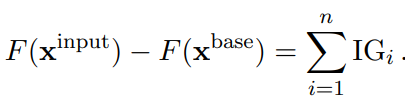

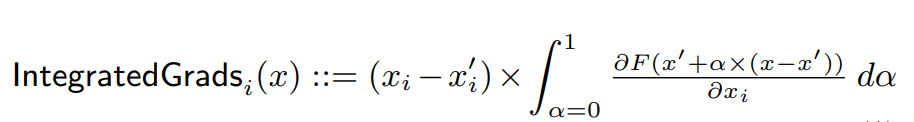

## Noise

A widely known issue for IG is noise. In the literature, many causes have been proposed:

* DNN model’s shape often has a high curvature
* Approximation of the integration with Riemann sum (I strongly disagree with this one)
* Choice of baselines

Many methods have been proposed to fix this issue. However, none of them has eliminated noise from the saliency map.

* Smooth-Grad: https://arxiv.org/pdf/1706.03825.pdf
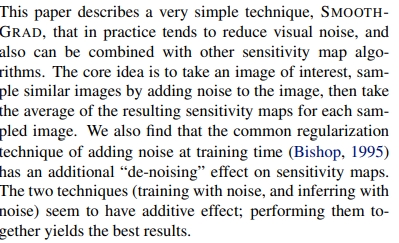
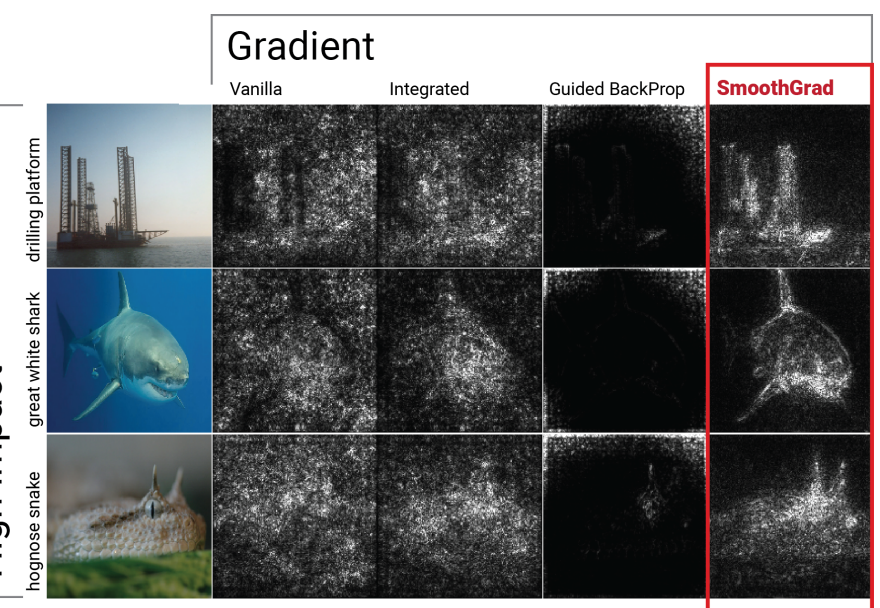

* Guided Integrated Gradients: https://openaccess.thecvf.com/content/CVPR2021/papers/Kapishnikov_Guided_Integrated_Gradients_An_Adaptive_Path_Method_for_Removing_Noise_CVPR_2021_paper.pdf
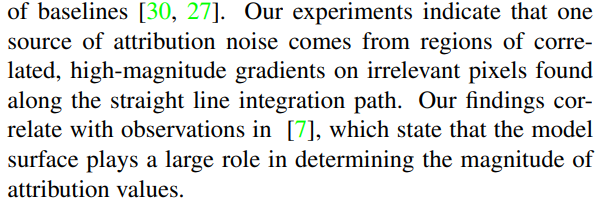
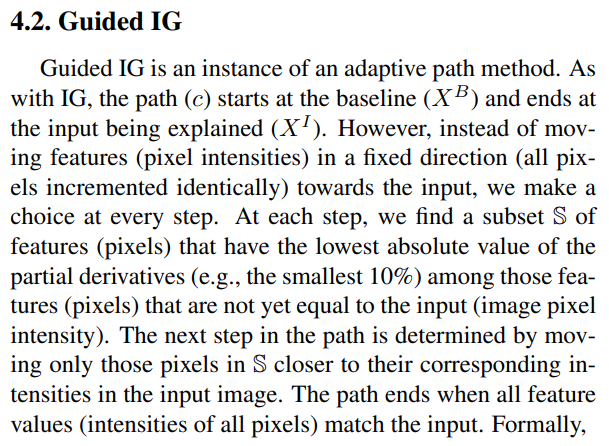
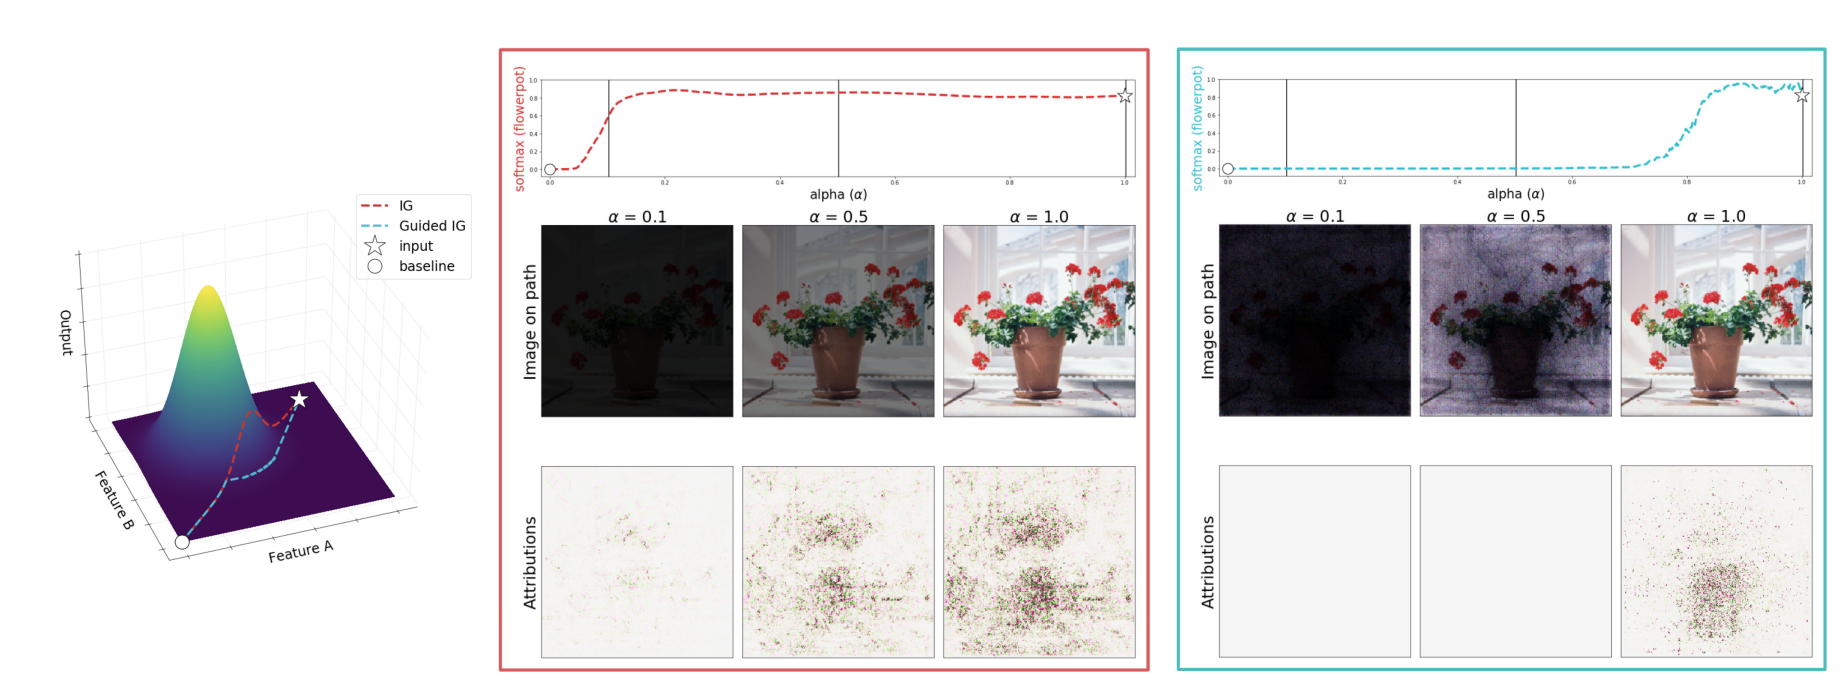

My guess is that this method assumes independence of features, which may not be true in images. In addition, other methods that assume independence of variables only perform an approximation of the "ideal" saliency map.

Bonus:

I found this interesting paper: https://arxiv.org/pdf/1906.07983.pdf

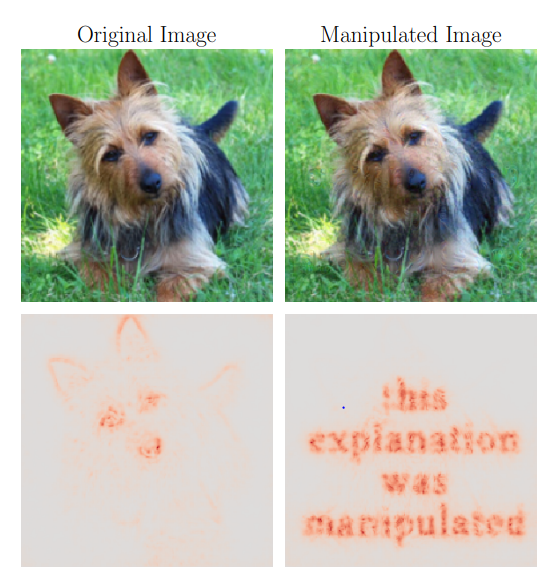